## Training M6 for FER with PyTorch

In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from torch.utils.data import TensorDataset, DataLoader

# Charger entraînement: Jaffe + pré-traitement avec dlib + lbp-var + 15 augmentations
x_train = np.load("db_transfigure/jaffe_dlib_var64_aug15_6emo_img.npy");      
y_train = np.load("db_transfigure/jaffe_dlib_var64_aug15_6emo_lab.npy");
x_train = x_train[500:1000][:][:];  y_train = y_train[500:1000][:][:];

# Charger testing: Jaffe + pré-traitement avec dlib + lbp-var
x_test = np.load("db_transfigure/jaffe_dlib_var64_test_6emo_img.npy");      
y_test = np.load("db_transfigure/jaffe_dlib_var64_test_6emo_lab.npy");
 
print("Ensemble des données: jaffe_dlib_var64_aug15_6emo_img.npy");
print("Img dat: ", x_train, x_train.shape, type(x_train), x_train[0]);
print("Taille des images: ",     x_train.shape, type(x_train));
print("Taille des étiquettes: ", y_train.shape, type(y_train));

# Convertir à PyTorch
x_train = torch.from_numpy(x_train);
y_train = torch.from_numpy(y_train);
x_test  = torch.from_numpy(x_test);
y_test  = torch.from_numpy(y_test);

# Create loaders à partir du tenseurs en *.npy 
trainset    = TensorDataset(x_train, y_train);
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2);
testset     = TensorDataset(x_test, y_test);
testloader  = torch.utils.data.DataLoader(testset, batch_size=1,
                                          shuffle=True, num_workers=2);
        
# Expressions: angry, disgust, fear, happy, sad, surprise, neutral
fer_eti = ["HA","AN","DI","FE","SA","SU"];                 # Expressions abrégés. 
fer_lab = [   0,   1,   2,   3,   4,  5 ];                 # Index des expressions.
  

Ensemble des données: jaffe_dlib_var64_aug15_6emo_img.npy
Img dat:  [[[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  4  3  2]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  1  0 ...  0  1  0]
  [ 0  1  1 ...  1  1  0]
  [ 0  0  0 ...  2  2  0]]

 [[ 3  3  3 ...  0  0  0]
  [ 4  3  5 ...  0  0  0]
  [ 6  4  3 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  3  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 ...

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ... 18 27 33]
  [ 0  0  0 ... 44 31 15]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 2  2  3 ...  0  0 

<class 'torch.Tensor'> torch.Size([1, 64, 64])
DI


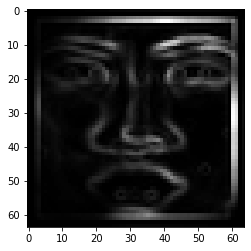

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next();

# show images
npimg = images[0].numpy();
plt.imshow(npimg, cmap="gray");
print(type(images[0]), images.shape);

# print labels
print(fer_eti[labels[0]]);

In [4]:
class M6FER_Net(nn.Module):
    def __init__(self):
        # Here all the layers are defined
        super(M6FER_Net, self).__init__()
        # Conv2d(#channels(rgb), #filters, kernel_size)
        self.conv1 = nn.Conv2d( 1,  32, 5);
        self.conv2 = nn.Conv2d(32,  64, 5);
        self.conv3 = nn.Conv2d(64, 128, 5);
        self.mpool = nn.MaxPool2d(2, 2);
        self.fc1   = nn.Linear(128 * 4 * 4, 6);

    def forward(self, x):
        # Here the model (network) structure is defined
        x = self.mpool(F.relu(self.conv1(x)));
        x = self.mpool(F.relu(self.conv2(x)));
        x = self.mpool(F.relu(self.conv3(x)));
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x);
        return x

net = M6FER_Net()

In [5]:
criterion = nn.CrossEntropyLoss(); # sparse categorical cross-entropy (i.e. tales integers as targets instead of one-hot vectors).
optimizer = optim.Adam(net.parameters(), lr=0.001);

In [6]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data;

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #outputs = net(inputs.float());
        outputs = net(inputs.view(1, inputs.shape[0], inputs.shape[1], inputs.shape[2]).float());
                
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0

print('Finished Training')

[1,   500] loss: 1.929
[2,   500] loss: 1.712
[3,   500] loss: 1.659
[4,   500] loss: 1.545
[5,   500] loss: 1.310
[6,   500] loss: 1.136
[7,   500] loss: 0.862
[8,   500] loss: 0.660
[9,   500] loss: 0.492
[10,   500] loss: 0.414
[11,   500] loss: 0.199
[12,   500] loss: 0.293
[13,   500] loss: 0.289
[14,   500] loss: 0.331
[15,   500] loss: 0.224
[16,   500] loss: 0.064
[17,   500] loss: 0.118
[18,   500] loss: 0.328
[19,   500] loss: 0.165
[20,   500] loss: 0.032
Finished Training


In [7]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        #outputs = net(images.float());
        outputs = net(images.view(1, images.shape[0], images.shape[1], images.shape[2]).float());
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 18 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 18 test images: 50 %
